In [0]:
# importing the dependencies
import keras
import itertools
import tensorflow as tf
from keras import backend as k
import numpy as np
import pandas as pd
from  matplotlib import pyplot as plt
from IPython.display import clear_output
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.layers import Dense,Flatten,BatchNormalization,Conv2D,MaxPooling2D,Dropout,AveragePooling2D
from sklearn.metrics import confusion_matrix

In [6]:
# Install a Drive FUSE wrapper.

# https://github.com/astrada/google-drive-ocamlfuse

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools

!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null

!apt-get update -qq 2>&1 > /dev/null

!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0

Setting up libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Setting up unattended-upgrades (0.98ubuntu1.1) ...

Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) 

In [0]:
# Generate auth tokens for Colab

from google.colab import auth 
auth.authenticate_user()

In [8]:
# Generate creds for the Drive FUSE library.

from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default()

import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL

vcode = getpass.getpass()

!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# Create a directory and mount Google Drive using that directory.

!mkdir -p drive

!google-drive-ocamlfuse drive

In [38]:
# reading the data file
data =pd.read_csv('drive/Colab Notebooks/data.csv')
print(data.head)

<bound method NDFrame.head of        emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
5            2  55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...     Training
6            4  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...     Training
7            3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...     Training
8            3  85 84 90 121 101 102 133 153 153 169 177 189 1...     Training
9            2  255 254 255 254 254 179 122 107 95 124 149 150...     Training
10           0  30 24 21 23 25 25 49 67 84 103 120 125 130 139...     Training
11           6  39 75 

In [0]:
# training data input
X = data['pixels']

In [0]:
# training data target output
y = data['emotion']

In [41]:
# splitting individual pixels so that we can feed it into neural network
new_x = []
i = 0

while i<35887:
    k = 0
    insert = [0] * 2304
    val = X[i]
    val = val.split(' ')
    count = 0
    while k<2304:
        insert[k] = (int)(val[k])
        # to make input between 0 and 1
        count = count + insert[k]
        k = k +1
    count = count /(48*48)
    k = 0
    while k<2304:
        insert[k] = (int)(val[k])
        # to make input between 0 and 1
        insert[k] = insert[k] - count
        k = k +1
    
    new_x.append(insert)
    i = i +1
new_x = np.asarray(new_x)
print('Done')

Done


In [0]:
# reshaping the input 
new_x  = np.reshape(new_x, (35887,48,48,1))
# setting X for the sake of consistency
X = new_x

In [0]:
# configuring the image generator
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(
                        zoom_range=.3,
                         horizontal_flip= True,
                         vertical_flip = True
                        )

In [43]:
print(y)

0        0
1        0
2        2
3        4
4        6
5        2
6        4
7        3
8        3
9        2
10       0
11       6
12       6
13       6
14       3
15       5
16       3
17       2
18       6
19       4
20       4
21       2
22       0
23       0
24       3
25       3
26       5
27       0
28       3
29       5
        ..
35857    5
35858    4
35859    4
35860    3
35861    6
35862    2
35863    5
35864    4
35865    3
35866    6
35867    3
35868    2
35869    3
35870    2
35871    6
35872    5
35873    4
35874    5
35875    5
35876    6
35877    6
35878    3
35879    2
35880    2
35881    0
35882    6
35883    3
35884    0
35885    3
35886    2
Name: emotion, Length: 35887, dtype: int64


In [0]:
# we will on hot encode y
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(encoded_y)

In [0]:
# training data
X_train = X[0:28710]
y_train = y[0:28710]

In [0]:
# testing data (leaderboard )
X_test_lb = X[28711:35888]
y_test_lb = y[28711:35888]

In [0]:
#This will help us to see the learning curve and detect over fitting 
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [78]:
# now we will build a model to learn input patameters
model = Sequential()

# First convolutional layer with max pooling
model.add(Conv2D(512, (3, 3), padding="same", input_shape=(48,48,1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.5))
model.add(BatchNormalization())


# third convolutional layer with max pooling
model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.5))
model.add(BatchNormalization())


# third convolutional layer with max pooling
model.add(Conv2D(128, (3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.5))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(1000))
model.add(Dropout(.5))
model.add(BatchNormalization())


model.add(Dense(512))
model.add(Dropout(.5))
model.add(BatchNormalization())


model.add(Dense(256))
model.add(Dropout(.5))
model.add(BatchNormalization())




# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(Dense(7, activation="softmax"))

# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="rmsprop",
              metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 48, 48, 512)       5120      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 24, 24, 512)       0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 24, 24, 512)       0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 24, 24, 512)       2048      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 24, 24, 256)       1179904   
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 12, 12, 256)       0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 12, 12, 256)       0         
__________

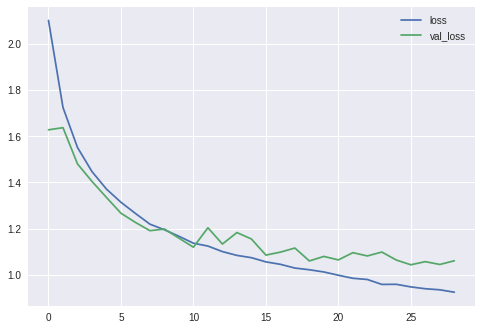

Epoch 30/40
 8000/28710 [=======>......................] - ETA: 41s - loss: 0.8973 - acc: 0.6635

KeyboardInterrupt: ignored

In [79]:
# fitting the model without data augmentation
model.fit(X_train, y_train,
          validation_data=[X_test_lb,y_test_lb],
          callbacks = [plot_losses],
          batch_size=500, 
          epochs=40, 
          verbose=1)



In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 512)       2560      
_________________________________________________________________
average_pooling2d_4 (Average (None, 24, 24, 512)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 24, 512)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 24, 512)       2048      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 256)       524544    
_________________________________________________________________
average_pooling2d_5 (Average (None, 12, 12, 256)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 12, 256)       0         
__________

In [80]:
y_pred = model.predict(X_test_lb,verbose = 1)

7176/7176 [==============================] - 7s 973us/step


In [0]:
y_pred = (np.argmax(y_pred,axis = 1))

In [0]:
y_test = (np.argmax(y_test_lb,axis = 1))

Confusion matrix, without normalization
[[ 510    3   57   75  172   21  119]
 [  36   44    2    5   14    4    5]
 [ 135    2  324   74  252  107  130]
 [  34    0   25 1528   73   28   86]
 [ 144    0   89   98  663   10  243]
 [  21    1   73   61   27  620   28]
 [  67    1   51  108  221   16  769]]
Normalized confusion matrix
[[5.33e-01 3.13e-03 5.96e-02 7.84e-02 1.80e-01 2.19e-02 1.24e-01]
 [3.27e-01 4.00e-01 1.82e-02 4.55e-02 1.27e-01 3.64e-02 4.55e-02]
 [1.32e-01 1.95e-03 3.16e-01 7.23e-02 2.46e-01 1.04e-01 1.27e-01]
 [1.92e-02 0.00e+00 1.41e-02 8.61e-01 4.11e-02 1.58e-02 4.85e-02]
 [1.15e-01 0.00e+00 7.14e-02 7.86e-02 5.32e-01 8.02e-03 1.95e-01]
 [2.53e-02 1.20e-03 8.78e-02 7.34e-02 3.25e-02 7.46e-01 3.37e-02]
 [5.43e-02 8.11e-04 4.14e-02 8.76e-02 1.79e-01 1.30e-02 6.24e-01]]


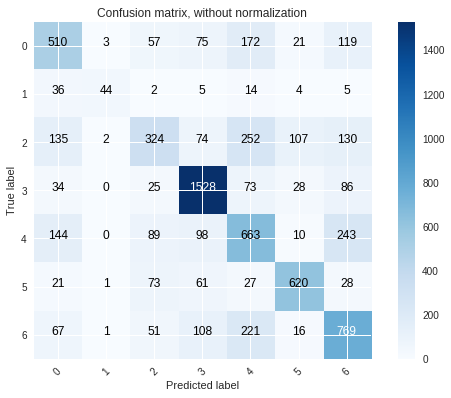

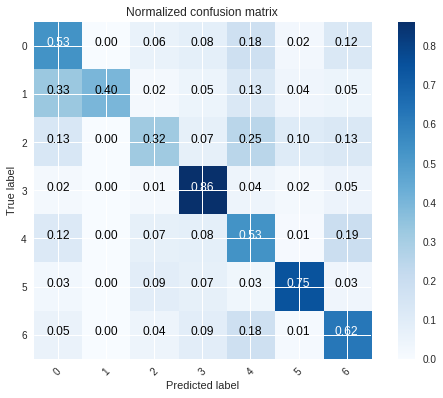

In [83]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1','2','3','4','5','6'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1','2','3','4','5','6'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [0]:
# to check how we scored on the public and private leaderboard
# outputs are given on the data file 


# reading the data file
data =pd.read_csv('drive/Colab Notebooks/data.csv')
# training data input
X = data['pixels']

# training data target output
y = data['emotion']
# testing data
y_test_lb = y[28711:35888]

In [85]:
new_x = []
i = 28711

while i<35887:
    k = 0
    insert = [0] * 2304
    val = X[i]
    val = val.split(' ')
    count = 0
    while k<2304:
        insert[k] = (int)(val[k])
        # to make input between 0 and 1
        count = count + insert[k]
        k = k +1
    count = count /(48*48)
    k = 0
    while k<2304:
        insert[k] = (int)(val[k])
        # to make input between 0 and 1
        insert[k] = insert[k] - count
        k = k +1
    
    new_x.append(insert)
    i = i +1
new_x = np.asarray(new_x)
print('Done')

Done


In [0]:
# forming the leaderboard test input
X_test_lb = np.reshape(X_test_lb , (7176,48,48,1))

In [87]:
# getting the input
output = model.predict(X_test_lb, verbose = 1,batch_size = 1)

7176/7176 [==============================] - 46s 6ms/step


In [88]:
print(output)
output = np.argmax(output, axis = 1)

[[7.01e-01 2.05e-02 6.05e-02 ... 1.76e-01 2.47e-03 3.96e-02]
 [1.31e-01 6.38e-02 1.66e-01 ... 3.23e-01 8.07e-03 2.84e-01]
 [3.43e-04 3.51e-05 2.67e-04 ... 3.07e-04 3.02e-04 1.40e-03]
 ...
 [1.94e-02 1.32e-05 4.33e-02 ... 4.65e-01 1.03e-03 4.44e-01]
 [1.35e-01 2.74e-03 3.22e-02 ... 2.83e-01 2.86e-04 1.29e-01]
 [8.62e-02 6.89e-03 4.30e-01 ... 4.15e-01 4.63e-03 5.36e-02]]


In [0]:
# checking how many predictions we have made correct
i = 0
count = 0
while i<7176:
    if output[i] == y_test_lb[i+28711]:
        count = count + 1
    else:
        count = count + 0
    i = i +1 

count = count /7176

In [90]:
print(count)

0.6212374581939799


In [0]:
model.save('drive/Colab Notebooks/new_model.h5')

In [123]:
img = cv2.imread('drive/Colab Notebooks/happy.jpg',0)
img = cv2.resize(img,(48,48))

i =0
j= 0 
count = 0

while i<48:
  while j<48:
    count = count + img[i][j]
    j = j +1
  i = i +1
count = count /(48*48)

i =0 
j = 0

print(img[0][1])
while i<48:
  while j<48:
    img[i][j] = img[i][j] - count
    
    j = j +1
  i = i +1
print(img[0][1])
img = np.reshape(img, (1,48,48,1))

248
243


In [124]:
output = model.predict(img)
print(output)

[[0.11 0.01 0.08 0.48 0.21 0.01 0.11]]


In [125]:
print(np.argmax(output,axis = 1))

[3]


In [126]:
img = cv2.imread('drive/Colab Notebooks/surprise.jpg',0)
img = cv2.resize(img,(48,48))
i =0
j= 0 
count = 0

while i<48:
  while j<48:
    count = count + img[i][j]
    j = j +1
  i = i +1
count = count /(48*48)

i =0 
j = 0

print(img[0][1])
while i<48:
  while j<48:
    img[i][j] = img[i][j] - count
    
    j = j +1
  i = i +1
print(img[0][1])
img = np.reshape(img, (1,48,48,1))
img = np.reshape(img, (1,48,48,1))

255
249


In [127]:
output = model.predict(img)
print(output)

[[0.03 0.01 0.26 0.03 0.45 0.03 0.2 ]]


In [128]:
print(np.argmax(output,axis = 1))

[4]


In [129]:
img = cv2.imread('drive/Colab Notebooks/sad.jpg',0)
img = cv2.resize(img,(48,48))
i =0
j= 0 
count = 0

while i<48:
  while j<48:
    count = count + img[i][j]
    j = j +1
  i = i +1
count = count /(48*48)

i =0 
j = 0

print(img[0][1])
while i<48:
  while j<48:
    img[i][j] = img[i][j] - count
    
    j = j +1
  i = i +1
print(img[0][1])
img = np.reshape(img, (1,48,48,1))
img = np.reshape(img, (1,48,48,1))

170
167


In [130]:
output = model.predict(img)
print(output)

[[0.21 0.   0.21 0.02 0.36 0.01 0.19]]


In [131]:
print(np.argmax(output,axis = 1))

[4]
